<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

##  HOW TO obtain Archival ESO Data Given RA and Dec - without using ESOAsg

The [ESO archive](http://archive.eso.org/cms.html) currently (June 2020) contains more than [1.7 million spectra](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=SPECTRUM&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22SPECTRUM%22%3atrue%7d&at=119.452774,-60.30286&sr=i), more than [650,000 images](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=IMAGE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22IMAGE%22%3atrue%7d&at=160.465004,19.501825&sr=i), and more than [240,000 cubes](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=CUBE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22CUBE%22%3atrue%7d&at=239.591811,-14.166308&sr=i) that are reduced or fully calibrated.

There are three main ways to access the vaste amount of information present in the [ESO archive](http://archive.eso.org/cms.html):

* the [Raw Data query form](http://archive.eso.org/eso/eso_archive_main.html)
* the [Science Portal](http://archive.eso.org/scienceportal/home) to browse and access the processed data
* the [Programmatic and Tools access](http://archive.eso.org/programmatic/) which permits direct database access to both raw and processed data, and to the ambient condition measurements

In addition, the <code>archive_observations</code> module part of the (unofficial) [ESOAsg](https://github.com/EmAstro/ESOAsg) package provides simple wrappers to efficiently embed the access to the [ESO archive](http://archive.eso.org/cms.html) into <code>python</code> routines.

With this example, we show how to obtain all science spectra associated to an object for which the location in the sky is known. 

In case you use data from the ESO Archive for your research, please consider the [ESO acknowledgement policies](http://archive.eso.org/cms/eso-data-access-policy.html#acknowledgement).

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Ashley Thomas Barnes


---
## <a id='imports'>0. Imports and instantiate the TAP service </a>

First, we import the necessary packages and define the [ESO Tabular Access Protocol (TAP) service](http://archive.eso.org/tap_obs) endpoint to query the reduced data. 

Next, we will instantiate the TAP service.


In [1]:
from pyvo.dal import tap  # Useful for interaction with online astronomical data services, allows querying databases
from astropy.coordinates import SkyCoord  # Module for handling astronomical coordinate systems
import astropy.constants as const  # Module for handling physical constants
import requests # Library for making HTTP requests
import os  # Library for interacting with the operating system
import cgi  # Library for parsing headers
import webbrowser # Library for opening web pages
from astropy.io import fits  # Module for reading and writing FITS files
import numpy as np  # Library for advanced numerical operations
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header

ESO_TAP_OBS = "https://archive.eso.org/tap_obs" # For the ESO TAP service
tapobs = tap.TAPService(ESO_TAP_OBS) # For the ESO TAP service

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


---
## <a id='RA/Dec'>1. Get RA and Dec of one target (or more) </a>

To begin, you need to choose the targets you would like to explore and get their coordinates. These need to be an [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/) `SkyCoord` object. A `SkyCoord` object can easily be created by using:

```python
from astropy import units as u
from astropy.coordinates import SkyCoord
coordinates = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
```

For this example, we consider a couple of standard stars observed as part of the [`MUSE library of stellar spectra`](https://www.eso.org/sci/publications/announcements/sciann17288.html) project ([Ivanov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.100I/abstract)): 
* [HD 057060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+057060&submit=SIMBAD+search)
* [HD 172230](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+172230&submit=SIMBAD+search).

The coordinates of these two well known stars can be simply retrieved from their name using `Sesame` (and we are storing them in the list: `star_positions`):

In [2]:
# Defining the position via SESAME name resolver

# Note - HD 057060 does not give centred coordinates 
# 
target_names = ['HD 057060', 'HD 172230'] #Define list of the targets

target_positions = []
for target_name in target_names:
    target_positions.append(SkyCoord.from_name(target_name, cache='update')) #Retrieve the coordinates of the target
    print('{}: {}'.format(target_name, SkyCoord.from_name(target_name).to_string('hmsdms')))

search_radius = 5./3600. # Define the search radius in degrees, 5 arcseconds for this example

HD 057060: 07h18m40.3789344s -24d33m31.318236s
HD 172230: 18h38m54.953904s +06d16m14.814048s


---
## <a id='query'>2. Query the archive </a>

The function <code>archive_observations.query_from_radec</code> allows to explore the processed data (also known as ADPs) within a certain radius in arcseconds (e.g., radius=5.) from a given position (e.g., for HD 057060: RA=109.66824871, Dec=-24.55869773). 

It is also possible to limit the search to specific instruments (e.g., 'MUSE', 'XSHOOTER', 'UVES') or specific data types (e.g., 'spectrum').

In practice, this corresponds to run the following [TAP query](https://archive.eso.org/programmatic/#TAP?f=txt&m=200&q=SELECT%0A%20%20%20%20target_name%2C%20dp_id%2C%20s_ra%2C%20s_dec%2C%20t_exptime%2C%20em_min%2C%20em_max%2C%20%0A%20%20%20%20dataproduct_type%2C%20instrument_name%2C%20obstech%2C%20abmaglim%2C%0A%20%20%20%20proposal_id%2C%20obs_collection%0AFROM%0A%20%20%20%20ivoa.ObsCore%0AWHERE%0A%20%20%20%20INTERSECTS(s_region%2CCIRCLE('ICRS'%2C109.66824871%2C-24.55869773%2C5.0%2F3600.))%3D1%0AAND%0A%20%20%20%20dataproduct_type%3D'spectrum'%0AAND%20%0A%20%20%20%20em_min%3E4.0e-7%20%0AAND%20%0A%20%20%20%20em_max%3C1.2e-6%20&'&):

```SQL
SELECT
    target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
    dataproduct_type, instrument_name, obstech, abmaglim,
    proposal_id, obs_collection
FROM
    ivoa.ObsCore
WHERE
    INTERSECTS(s_region,CIRCLE('ICRS',109.66824871,-24.55869773,5.0/3600.))=1
AND
    dataproduct_type='spectrum'
AND 
    em_min>4.0e-7 
AND 
    em_max<1.2e-6 
```

In this example, we are interested only to the optical data, so we limit the result of the queries to:

`em_min>4.0e-7 & em_max<1.2e-6`

where the limits in wavelength are expressed in meters. In other words, we are limiting the wavelength coverage to:

$4000 \mathring A < \lambda < 12000 \mathring A$

In [3]:
# # Cone search: looking for reduced datasets intersecting a circle of 5'' around Beta Pictoris

queries = []
for target_position in target_positions:

    query = """
        SELECT 
            target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
            dataproduct_type, instrument_name, obstech, abmaglim,
            proposal_id, obs_collection
        FROM 
            ivoa.ObsCore
        WHERE 
            intersects(s_region, circle('ICRS', %f, %f, %f))=1
        AND 
            dataproduct_type in ('spectrum')
        AND 
            em_min>4.0e-7 
        AND 
            em_max<1.2e-6
        ORDER BY SNR DESC
        """ % (target_position.ra.degree, target_position.dec.degree, search_radius)

    queries.append(query)

In [4]:
print(queries[0])  # Print the query for the first target


        SELECT 
            target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
            dataproduct_type, instrument_name, obstech, abmaglim,
            proposal_id, obs_collection
        FROM 
            ivoa.ObsCore
        WHERE 
            intersects(s_region, circle('ICRS', 109.668246, -24.558700, 0.001389))=1
        AND 
            dataproduct_type in ('spectrum')
        AND 
            em_min>4.0e-7 
        AND 
            em_max<1.2e-6
        ORDER BY SNR DESC
        


In [5]:
print(queries[1])  # Print the query for the first target


        SELECT 
            target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
            dataproduct_type, instrument_name, obstech, abmaglim,
            proposal_id, obs_collection
        FROM 
            ivoa.ObsCore
        WHERE 
            intersects(s_region, circle('ICRS', 279.728975, 6.270782, 0.001389))=1
        AND 
            dataproduct_type in ('spectrum')
        AND 
            em_min>4.0e-7 
        AND 
            em_max<1.2e-6
        ORDER BY SNR DESC
        


In [6]:
result_from_queries = []
result_from_queries_table = []
result_from_queries_len = []

for query in queries: 

    print("[WORKING] Running query %i to the ESO archive (out of %i total)" % (queries.index(query)+1, len(queries)))

    result_from_query = tapobs.search(query=query) #Maximum records to return
    result_from_query_table = result_from_query.to_table()
    result_from_query_len = len(result_from_query_table)

    result_from_queries.append(result_from_query)
    result_from_queries_table.append(result_from_query_table)
    result_from_queries_len.append(result_from_query_len)

    print("A total of %i entries has been retrieved" % result_from_query_len)

[WORKING] Running query 1 to the ESO archive (out of 2 total)
A total of 16 entries has been retrieved
[WORKING] Running query 2 to the ESO archive (out of 2 total)
A total of 6 entries has been retrieved


The results are stored in a list of astropy tables (one table per position). 

In [7]:
result_from_queries_table[0].show_in_notebook(show_row_index=False)

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
UW CMa,ADP.2024-11-11T14:37:21.583,109.668353,-24.55882,599.998,4.58307e-07,6.68642e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-12-04T10:29:39.699,109.66816,-24.55895,299.999,4.58308e-07,6.68645e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-11-11T14:31:22.374,109.668245,-24.55866,299.999,4.58308e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-11-11T14:32:23.771,109.668158,-24.55871,299.999,4.58307e-07,6.68644e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-12-04T10:24:25.398,109.668133,-24.55894,299.999,4.58308e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-11-11T14:29:38.651,109.66832,-24.55885,299.999,4.58307e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-12-04T10:51:42.839,109.66825,-24.55845,299.999,4.58307e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-12-04T10:38:34.752,109.668344,-24.55878,299.999,4.58307e-07,6.68644e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
UW CMa,ADP.2024-12-04T10:51:42.804,109.66825,-24.55845,74.999,4.58307e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES


In [8]:
result_from_queries_table[1].show_in_notebook(show_row_index=False)

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
HD 172230,ADP.2020-02-26T15:36:25.276,279.728983,6.270793,24.0,4.75021e-07,9.35146e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD
HD_172230,ADP.2021-09-16T14:46:40.723,279.728885,6.27061,119.996,4.72686e-07,6.83508e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD_172230,ADP.2021-09-16T14:46:40.592,279.728906,6.27063,99.998,6.650249999999999e-07,1.042609e-06,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:52.997,279.729582,6.27016,2.2,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
HD172230,ADP.2020-07-28T07:32:26.286,279.728958,6.270786,2.2,5.33736e-07,1.0201269999999999e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSL
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.210,279.729289,6.27105,0.1,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER


---

## <a id='downloading_data'>2. Preprocessing and downloading the Data </a>

### <a id='cutouts'>2.1 Defining Spectral Cutouts Prior to Data Download</a>

In this section, we first create cutouts of specific spectral regions before downloading the data. For this analysis, we focus on selecting files that fall within a defined wavelength range (`wave_range`) to examine a region of interest, specifically around the CaII K line. To keep things organized, we will create a directory to store the files we download.

In [9]:
# Specify the parent directory; update this to match your own directory structure
output_dir='./data/' 

# Check if the folder already exists, and create it if it does not
if os.path.exists(output_dir):
    print('The folder already exists')
else:
    os.mkdir(output_dir)
    print('Folder successfully created')

The folder already exists


---
## <a id='RA/Dec'>3. Download the Archive Data Products </a>

Previoulsy, we define functions to handle the retrieval and storage of FITS files from HTTP responses. 

In [10]:
def getDispositionFilename( response ): #get the filename from the header
    """Get the filename from the Content-Disposition in the response's http header"""
    contentdisposition = response.headers.get('Content-Disposition')
    if contentdisposition == None:
        return None
    value, params = cgi.parse_header(contentdisposition)
    filename = params["filename"]
    return filename

def writeFile( response, folder_path ): #write content of file on disk
    """Write on disk the retrieved file specifying a folder path"""
    if response.status_code == 200:
        # The ESO filename can be found in the response header
        filename = getDispositionFilename( response )
        # Let's write on disk the downloaded FITS spectrum using the ESO filename:
        full_path = os.path.join(folder_path, filename)
        with open(full_path, 'wb') as f:
            f.write(response.content)
        return filename 

We download FITS files from the [ESO Data Portal](https://dataportal.eso.org/dataportal_new/file/) using a specified base URL and save them to a designated folder. The process involves iterating through the query results to download and store each file on disk. 

In [11]:
#Base URL for downloading files from the ESO data portal
beg = 'https://dataportal.eso.org/dataportal_new/' 
notfiles = []

for ii in range(len(result_from_queries_table)): # Iterate through the number of targets
    for jj in range(result_from_queries_len[ii]): # Iterate through the number of matching datasets for each target
    
        target_namem, obs_collection = result_from_queries_table[ii][jj]['target_name', 'obs_collection']

        # Construct the full URL for the file download
        filebeg = f"{beg}soda/sync?ID={result_from_queries_table[ii][jj]['dp_id']}"

        response = requests.get(filebeg)

        # Write the file to disk and get the filename
        filename = writeFile(response, output_dir) 

        if str(filename)!='None':
            # Print the index and filename if the file was successfully saved
            print("Successfully Downloaded: %i - %s - %s - %s" % (jj, target_namem, obs_collection, filename)) 
        else:
            # Print an error message if the file could not be retrieved
            print("Not Downloaded (status %s): %i - %s - %s - %s" % (response.status_code, jj, target_namem, obs_collection, filename)) 

Not Downloaded (status 401): 0 - UW CMa - UVES - None
Not Downloaded (status 401): 1 - UW CMa - UVES - None
Not Downloaded (status 401): 2 - UW CMa - UVES - None
Not Downloaded (status 401): 3 - UW CMa - UVES - None
Not Downloaded (status 401): 4 - UW CMa - UVES - None
Not Downloaded (status 401): 5 - UW CMa - UVES - None
Not Downloaded (status 401): 6 - UW CMa - UVES - None
Not Downloaded (status 401): 7 - UW CMa - UVES - None
Not Downloaded (status 401): 8 - UW CMa - UVES - None
Not Downloaded (status 401): 9 - UW CMa - UVES - None
Not Downloaded (status 401): 10 - UW CMa - UVES - None
Successfully Downloaded: 11 - HD_57060 - UVES - ADP.2020-07-10T21:41:17.417_cut0.fits
Successfully Downloaded: 12 - HD_57060 - UVES - ADP.2020-07-10T21:41:17.392_cut0.fits
Successfully Downloaded: 13 - HD057060 - XSL - ADP.2020-07-28T07:32:26.167_cut0.fits
Successfully Downloaded: 14 - 2MASS-J07184037-2433312 - XSHOOTER - ADP.2017-06-02T19:41:04.876_cut0.fits
Successfully Downloaded: 15 - HD 057060 - M

In [12]:
webbrowser.open(filebeg)

True

---
## <a id='explore_data'>4. Explore the data... </a>

Now the `MUSE`, `XSHOOTER`, and `UVES` optical spectra of `HD 057060` and `HD 172230` are on disk. You can explore them with your favourite tools. 

### <a id='HD 057060'> HD 057060 </a>

#### <a> Extract the data for HD 057060 </a>

Normalize spectra from different instrument at $8000 \mathring A$ and show the different shapes:

In [13]:
hdu_muse =      fits.open('./data/ADP.2020-02-26T15:36:25.254.fits') # MUSE dataset
hdu_xshooter = fits.open('./data/ADP.2020-07-28T07:32:26.167.fits') # XSHOOTER dataset
hdu_uves1 =     fits.open('./data/ADP.2020-07-10T21:41:17.392.fits') # UVES dataset 
hdu_uves2 =     fits.open('./data/ADP.2020-07-10T21:41:17.417.fits') # UVES dataset

Extract the spectral information for plotting with the following ``extract_spectrum`` function. 
This applies the wavelengths corrections to get everything in ``SPECSYS`` in ``BARYCENT`` (from ``TOPOCENT`` or ``SOURCE``).
Some of the data do not have the correction factors for ``TOPOCENT`` so we calculate this from ``PyAstronomy`` package. 
Here we impose ``check_bary`` to see the correction factors, but they are only applied to the ``UVES`` data.

In [14]:
def extract_spectrum(hdu, instrument, verbose=False, check_bary=False):
    
    hdu_0 = hdu[0]
    hdu_1 = hdu[1]

    print(f'SPECSYS for {instrument}: {hdu_0.header["SPECSYS"]}')

    # Shifting to Ang.
    if hdu_1.header['TUNIT1'] == 'nm':
        wave_corr = 10. # Get to Ang.
    else:
        wave_corr = 1. # Already in Ang.

    # Perform barycentric correction
    if 'HIERARCH ESO QC VRAD BARYCOR' in hdu_0.header: 
        barycorr = hdu_0.header['HIERARCH ESO QC VRAD BARYCOR']
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr}')
        
    elif 'HELICORR' in hdu_0.header:
        barycorr = hdu_0.header['HELICORR']
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr}')

    no_bary = (hdu_0.header["SPECSYS"] == 'TOPOCENT') and ('HIERARCH ESO QC VRAD BARYCOR' not in hdu_0.header)
    if no_bary or check_bary: 
    
        ra = hdu[0].header['RA']
        dec = hdu[0].header['DEC']
        mjd = hdu[0].header['MJD-OBS'] # Modified JD for the observation
        jd = mjd + 2400000.5 # JD for the observation
        heliocorr, barycorr = pyasl.baryCorr(jd, ra, dec)
        if no_bary:
            wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr} (using PyAstronomy)')
        
    if hdu_0.header['SPECSYS'] == 'SOURCE':
        sourcecorr = hdu_0.header['REST_VAL']
        wave_corr *= (1. + (sourcecorr/const.c.to('km/s').value))
        print(f'Source correction for {instrument}: {sourcecorr}')

    if instrument == 'MUSE':
        # No corrections needed for the MUSE spectrum - 'erg cm**(-2) s**(-1) angstrom**(-1)'
        flux_corr = 1.
    
    elif instrument == 'XSHOOTER':
        # No corrections needed for the MUSE spectrum - 'erg cm**(-2) s**(-1) angstrom**(-1)'
        flux_corr = 1.
    
    elif instrument == 'UVES':
        # Correcting the UVES spectrum by factor 1e-16 - 'erg s**(-1) cm**(-2) angstrom**(-1)'
        flux_corr = 1e-16
    
    spec_wave = hdu_1.data['WAVE'].squeeze() * wave_corr
    spec_flux = hdu_1.data['FLUX'].squeeze() * flux_corr
    spec_err = hdu_1.data['ERR'].squeeze() * flux_corr    

    spec_flux[spec_flux==0] = np.nan
    spec_err[spec_err==0] = np.nan
    
    if verbose:
        print('Content of the {} spectrum: \n {} \n'.format(instrument, hdu_1.columns))
        
    return spec_wave, spec_flux, spec_err    

# Extract the spectra from the FITS files
# The function returns the wavelength, flux and flux error of the spectrum for each instrument in an array
spec_muse_wave, spec_muse_flux, spec_muse_fluxerr = extract_spectrum(hdu_muse, 'MUSE', verbose=False, check_bary=True)
spec_xshooter_wave, spec_xshooter_flux, spec_xshooter_fluxerr = extract_spectrum(hdu_xshooter, 'XSHOOTER', verbose=False, check_bary=True)
spec_uves1_wave, spec_uves1_flux, spec_uves1_fluxerr = extract_spectrum(hdu_uves1, 'UVES', verbose=False, check_bary=True)
spec_uves2_wave, spec_uves2_flux, spec_uves2_fluxerr = extract_spectrum(hdu_uves2, 'UVES', verbose=False, check_bary=True) 

SPECSYS for MUSE: BARYCENT
Barycentric correction for MUSE: -19.668036026656434 (using PyAstronomy)
SPECSYS for XSHOOTER: SOURCE
Barycentric correction for XSHOOTER: -7.964341988998585 (using PyAstronomy)
Source correction for XSHOOTER: -137.6
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 18.306386092204512 (using PyAstronomy)
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 18.307295784008847 (using PyAstronomy)


Here we rescale the two UVES spectra to the same level, as we have the short and longer wavelengths to combine.

In [15]:
def rescale_uves(spec_uves1_wave, spec_uves2_wave, spec_uves1_flux, spec_uves2_flux, wave_min = 6710, wave_max = 6790):

    """
    Rescale the flux of the two UVES spectra to the same level in the region between wave_min and wave_max.

    Parameters
    spec_uves1_wave (numpy.ndarray): wavelength of the first UVES spectrum
    spec_uves2_wave (numpy.ndarray): wavelength of the second UVES spectrum
    spec_uves1_flux (numpy.ndarray): flux of the first UVES spectrum
    spec_uves2_flux (numpy.ndarray): flux of the second UVES spectrum
    wave_min (float): minimum wavelength to consider for the rescaling
    wave_max (float): maximum wavelength to consider for the rescaling
    """

    spec_uves1_wave_mask = (spec_uves1_wave>wave_min) & (spec_uves1_wave<wave_max)
    spec_uves2_wave_mask = (spec_uves2_wave>wave_min) & (spec_uves2_wave<wave_max)

    spec_uves1_flux_masked = spec_uves1_flux[spec_uves1_wave_mask]
    spec_uves2_flux_masked = spec_uves2_flux[spec_uves2_wave_mask]

    rescaling_factor_uves1 = np.nanmean(np.append(spec_uves1_flux_masked, spec_uves2_flux_masked)) / np.nanmean(spec_uves2_flux_masked)
    rescaling_factor_uves2 = np.nanmean(np.append(spec_uves1_flux_masked, spec_uves2_flux_masked)) / np.nanmean(spec_uves1_flux_masked)

    spec_uves1_flux = spec_uves1_flux / rescaling_factor_uves1
    spec_uves2_flux = spec_uves2_flux / rescaling_factor_uves2

    return spec_uves1_flux, spec_uves2_flux

spec_uves1_flux, spec_uves2_flux = rescale_uves(spec_uves1_wave, spec_uves2_wave, spec_uves1_flux, spec_uves2_flux)

Rescale the flux of the XSHOOTER and UVES spectra to the same level as the MUSE spectrum in the region between 7950 and 8050 Angstrom.

In [16]:
def rescale_spectrum(spex_wave, spec_flux, wave_min=7950, wave_max=8050):
    """
    Rescale the flux of the spectrum to the same level in the region between wave_min and wave_max.

    Parameters
    spex_wave (numpy.ndarray): wavelength of the spectrum
    spec_flux (numpy.ndarray): flux of the spectrum
    wave_min (float): minimum wavelength to consider for the rescaling
    wave_max (float): maximum wavelength to consider for the rescaling

    Returns
    norm (float): normalization factor
    """

    norm = np.nanmedian(spec_flux[(spex_wave>wave_min) & (spex_wave<wave_max)])
    return norm

norm_muse = rescale_spectrum(spec_muse_wave, spec_muse_flux)
norm_xshooter = rescale_spectrum(spec_xshooter_wave, spec_xshooter_flux)
norm_uves1 = rescale_spectrum(spec_uves1_wave, spec_uves1_flux)

spec_xshooter_flux_rescaled = spec_xshooter_flux * (norm_muse / norm_xshooter)
spec_uves1_flux_rescaled = spec_uves1_flux * (norm_muse / norm_uves1)
spec_uves2_flux_rescaled = spec_uves2_flux * (norm_muse / norm_uves1)

#### <a> Plot the data for HD 057060 </a>

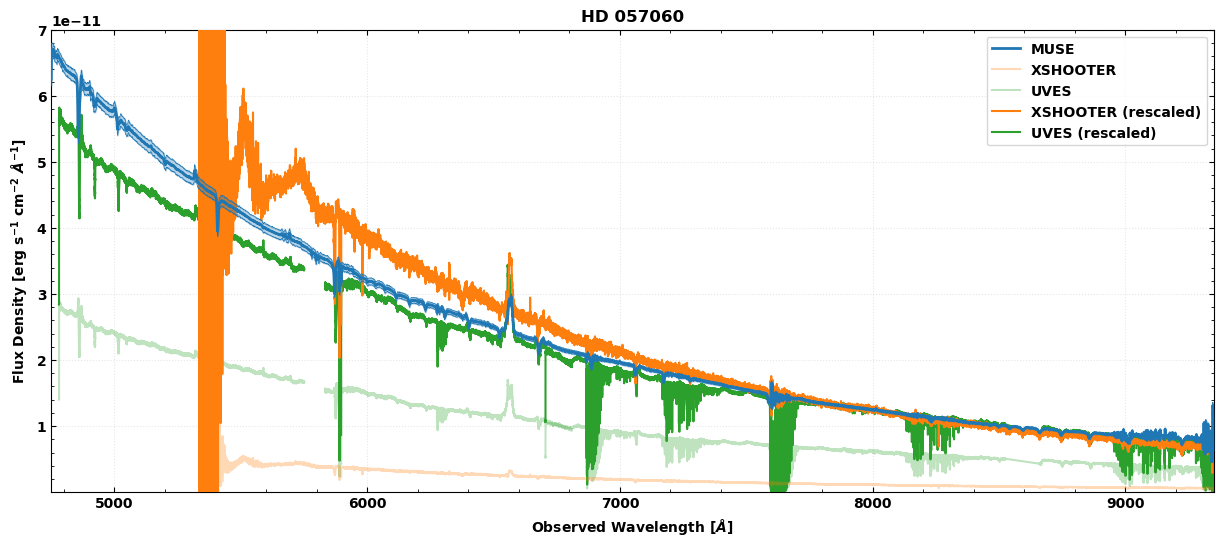

In [17]:
# Plot re-normalized spectra
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

ax.plot(spec_muse_wave, spec_muse_flux, c='C0', label='MUSE', zorder=4, lw=2)
ax.fill_between(spec_muse_wave, spec_muse_flux-spec_muse_fluxerr, spec_muse_flux+spec_muse_fluxerr, color='C0', alpha=0.3, zorder=4)
ax.plot(spec_muse_wave, spec_muse_flux-spec_muse_fluxerr, c='C0', zorder=4, lw=0.5)
ax.plot(spec_muse_wave, spec_muse_flux+spec_muse_fluxerr, c='C0', zorder=4, lw=0.5)

ax.plot(spec_xshooter_wave, spec_xshooter_flux, c='C1', alpha=0.3, label='XSHOOTER', zorder=3)
ax.plot(spec_uves1_wave, spec_uves1_flux, c='C2', alpha=0.3, label='UVES', zorder=2)
ax.plot(spec_uves2_wave, spec_uves2_flux, c='C2', alpha=0.3, zorder=2)

ax.plot(spec_xshooter_wave, spec_xshooter_flux_rescaled, label=r'XSHOOTER (rescaled)', c='C1', zorder=3)
ax.plot(spec_uves1_wave, spec_uves1_flux_rescaled, label=r'UVES (rescaled)', c='C2', zorder=2)
ax.plot(spec_uves2_wave, spec_uves2_flux_rescaled, c='C2', zorder=2)

ax.set_xlim(min(spec_muse_wave), max(spec_muse_wave))
ax.set_ylim(0.1e-12, 7e-11)
ax.set_xlabel(r'Observed Wavelength [$\AA$]')
ax.set_ylabel(r'Flux Density [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.set_title(r'HD 057060')

ax.legend(loc='upper right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('figures/HD057060.png', format='png', bbox_inches='tight')

### <a id='HD 172230'> HD 172230 </a>

#### <a> Extract the data for HD 172230 </a>

Cross calibrate wavelength solution to the highest resolution instrument and calculate radial velocities

In [18]:
hdu_muse =      fits.open('./data/ADP.2020-02-26T15:36:25.276.fits') # MUSE dataset
hdu_xshooter =  fits.open('./data/ADP.2020-07-28T07:32:26.286.fits') # XSHOOTER dataset
hdu_uves =      fits.open('./data/ADP.2021-09-16T14:46:40.723.fits') # UVES dataset

In [19]:
spec_muse_wave, spec_muse_flux, spec_muse_fluxerr = extract_spectrum(hdu_muse, 'MUSE', verbose=False)
spec_xshooter_wave, spec_xshooter_flux, spec_xshooter_fluxerr = extract_spectrum(hdu_xshooter, 'XSHOOTER', verbose=False, check_bary=True)
spec_uves_wave, spec_uves_flux, spec_uves_fluxerr = extract_spectrum(hdu_uves, 'UVES', verbose=False)

SPECSYS for MUSE: BARYCENT
SPECSYS for XSHOOTER: SOURCE
Barycentric correction for XSHOOTER: -6.42726916170844 (using PyAstronomy)
Source correction for XSHOOTER: -43.81
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 16.431138246234468 (using PyAstronomy)


Here we subtract the continuum level from the spectrum as we're interested in plotting only lines. 

In [20]:
def continuum_subtraction(wave, flux, wl_left_min=6423, wl_left_max=6428, wl_right_min=6685, wl_right_max=6690, poly_order=1):

    """ 
    Continuum subtraction using a polynomial fit 
    
    Parameters: 
    wavelength (numpy.ndarray): Array of wavelengths.
    flux (numpy.ndarray): Array of fluxes.
    wl_left_min (float): Minimum wavelength of the left continuum region.
    wl_left_max (float): Maximum wavelength of the left continuum region.
    wl_right_min (float): Minimum wavelength of the right continuum region.
    wl_right_max (float): Maximum wavelength of the right continuum region.
    poly_order (int): Order of the polynomial fit.

    Returns:
    flux_normalized (numpy.ndarray): Array of normalized fluxes.
    """

    poly_mask = (( (wave > wl_left_min) & (wave < wl_left_max) ) |
                    ( (wave > wl_right_min) & (wave < wl_right_max) ))
    poly_coeff = np.polyfit(np.log10(wave[poly_mask]), np.log10(flux[poly_mask]), deg=poly_order)
    flux_normalized = flux / 10.**(np.polyval(poly_coeff, np.log10(wave)))
    return flux_normalized

spec_muse_flux_normalized = continuum_subtraction(spec_muse_wave, spec_muse_flux)
spec_xshooter_flux_normalized = continuum_subtraction(spec_xshooter_wave, spec_xshooter_flux)
spec_uves_flux_normalized = continuum_subtraction(spec_uves_wave, spec_uves_flux)

spec_muse_fluxerr_normalized = spec_muse_flux_normalized * (spec_muse_fluxerr / spec_muse_flux)

In [21]:
def calculate_velocity(wavelength, reference_wavelength=6562.793):
    """
    Calculate the velocity relative to a given reference wavelength.

    Parameters:
    wavelength (numpy.ndarray): Array of wavelengths.
    reference_wavelength (float): The reference wavelength to calculate the velocity. Default is 6562.793 (H-alpha line).

    Returns:
    numpy.ndarray: Array of velocities in km/s.
    """
    return (wavelength / reference_wavelength - 1) * const.c.to('km/s').value

spec_uves_vel = calculate_velocity(spec_uves_wave)
spec_xshooter_vel = calculate_velocity(spec_xshooter_wave)
spec_muse_vel = calculate_velocity(spec_muse_wave)

#### <a> Plot the data for HD 172230 </a>

First, we check the H-alpha absorption towards the star observed with ``MUSE``, ``XSHOOTER``, and ``UVES``, which very nicely shows the difference in spectra resolution between the instruments. 

Note that we apply a small offset to the ``XSHOOTER`` data.

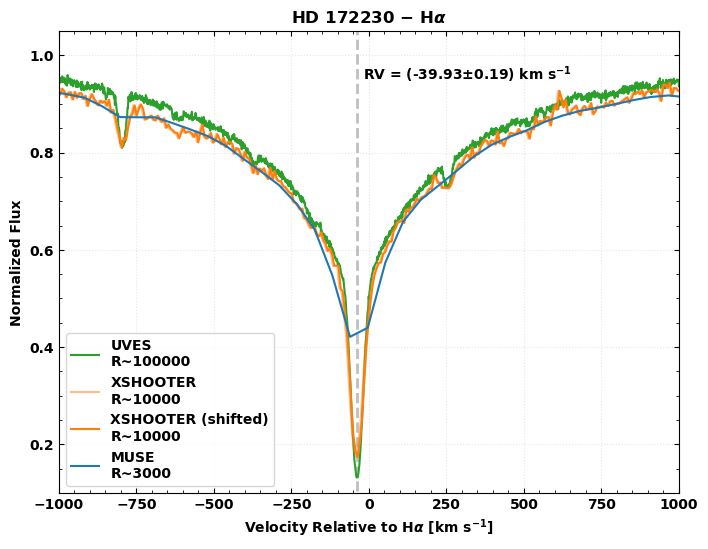

In [22]:
# Plot re-normalized spectra
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

radial_velocity = -39.93 # km/s
ax.plot([radial_velocity]*2, [-1,2], c='k', ls='--', lw=2, alpha=0.25)

ax.plot(spec_uves_vel, spec_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='C2')
ax.plot(spec_xshooter_vel, spec_xshooter_flux_normalized, label=r'XSHOOTER' + '\n' + 'R~10000', c='C1', alpha=0.5)
shift = 4
ax.plot(spec_xshooter_vel+shift, spec_xshooter_flux_normalized, label=r'XSHOOTER (shifted)' + '\n' + 'R~10000', c='C1')
ax.plot(spec_muse_vel, spec_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='C0')

ax.set_xlim(-1000., 1000.)
ax.set_ylim(0.1, 1.05)
ax.text(radial_velocity+20, 0.95, r'RV = (-39.93$\pm$0.19) km s$^{-1}$', horizontalalignment='left')
ax.set_xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')
ax.set_ylabel(r'Normalized Flux')
ax.set_title(r'HD 172230 $-$ H$\alpha$')

ax.legend(loc='lower left')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/HD172230_6562.png', format='png', bbox_inches='tight')

Here we focus on a number of other lines (CaI, FeI, BaII). 

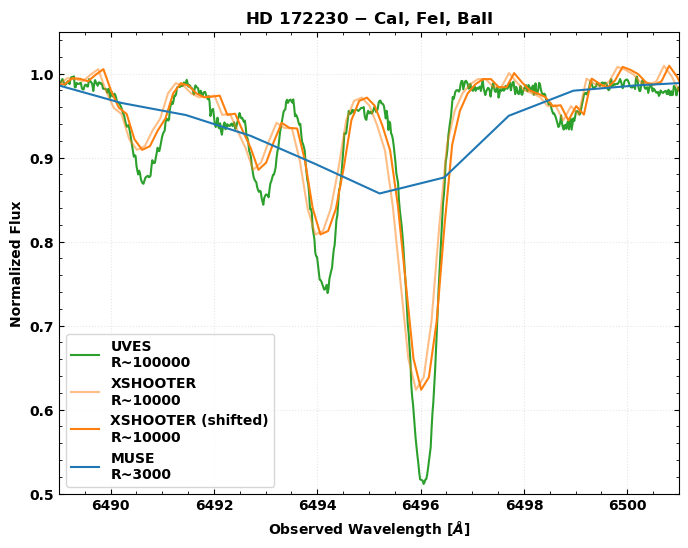

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(spec_uves_wave, spec_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='C2')
ax.plot(spec_xshooter_wave, spec_xshooter_flux_normalized, label=r'XSHOOTER' + '\n' + 'R~10000', c='C1', alpha=0.5)
shift = 0.1
ax.plot(spec_xshooter_wave+shift, spec_xshooter_flux_normalized, label=r'XSHOOTER (shifted)' + '\n' + 'R~10000', c='C1')

ax.plot(spec_muse_wave, spec_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='C0')

ax.set_xlim(6495.-6., 6495.+6.)
ax.set_ylim(0.5, 1.05)
ax.set_xlabel(r'Observed Wavelength [$\AA$]')
ax.set_ylabel(r'Normalized Flux')
ax.set_title(r'HD 172230 $-$ CaI, FeI, BaII')

ax.legend(loc='lower left')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/HD172230_6490.png', format='png', bbox_inches='tight')